In [4]:
import os

os.chdir(r"C:\Users\i-ryb\Desktop\fire_forecast_kurgan")
os.getcwd()


'C:\\Users\\i-ryb\\Desktop\\fire_forecast_kurgan'

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np


D:\Anaconda\Lib\site-packages\pandas\core\arrays\masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [5]:
fires_snp = pd.read_csv("data_raw/fires_viirs/VIIRS_NOAA20.csv")
fires_noaa = pd.read_csv("data_raw/fires_viirs/VIIRS_S_NPP.csv")

fires_all = pd.concat([fires_snp, fires_noaa], ignore_index=True)


In [6]:
fires_gdf = gpd.GeoDataFrame(
    fires_all,
    geometry=gpd.points_from_xy(
        fires_all.longitude,
        fires_all.latitude
    ),
    crs="EPSG:4326"
)


In [7]:
region = gpd.read_file("data_raw/boundaries/kurgan.geojson").to_crs(epsg=32642)
grid = gpd.read_file("data_interim/grids/grid_500m_kurgan.geojson")


In [8]:
fires_gdf = fires_gdf.to_crs(grid.crs)
fires_kurgan = fires_gdf[fires_gdf.within(region.geometry.iloc[0])]


In [9]:
fires_with_cells = gpd.sjoin(
    fires_kurgan,
    grid[["cell_id", "geometry"]],
    how="left",
    predicate="within"
)


In [10]:
fire_counts = (
    fires_with_cells
    .dropna(subset=["cell_id"])
    .groupby("cell_id")
    .size()
    .rename("fire_count")
    .reset_index()
)

grid = grid.merge(fire_counts, on="cell_id", how="left")
grid["fire_count"] = grid["fire_count"].fillna(0)
grid["y"] = (grid["fire_count"] > 0).astype(np.int8)


<Axes: >

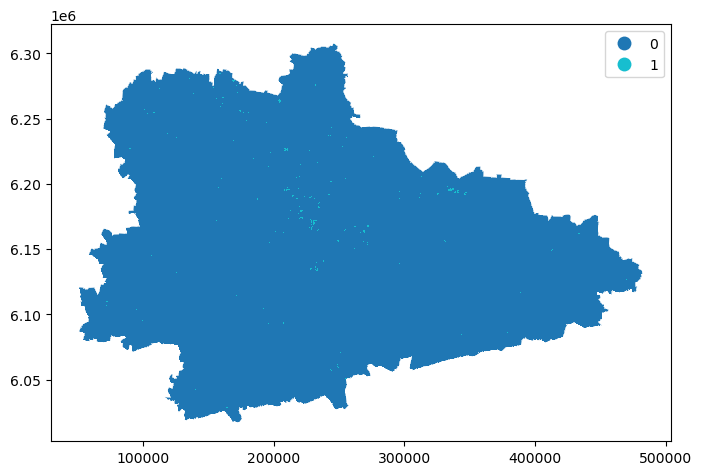

In [11]:
grid.plot(column="y", categorical=True, legend=True, figsize=(8, 8))


In [12]:
grid.to_file("data_processed/grid_with_y_kurgan.geojson", driver="GeoJSON")


In [13]:
import geopandas as gpd

grid = gpd.read_file("data_processed/grid_with_y_kurgan.geojson")


In [14]:
grid.columns


Index(['name', 'cartodb_id', 'created_at', 'updated_at', 'name_latin',
       'cell_id', 'fire_count', 'y', 'geometry'],
      dtype='object')

In [15]:
grid.dtypes


name                             object
cartodb_id                        int32
created_at    datetime64[ms, UTC+01:00]
updated_at    datetime64[ms, UTC+01:00]
name_latin                       object
cell_id                           int32
fire_count                      float64
y                                 int32
geometry                       geometry
dtype: object

In [16]:
grid["y"].value_counts()


y
0    288581
1       576
Name: count, dtype: int64

In [17]:
(grid["fire_count"] > 0).equals(grid["y"] == 1)


True

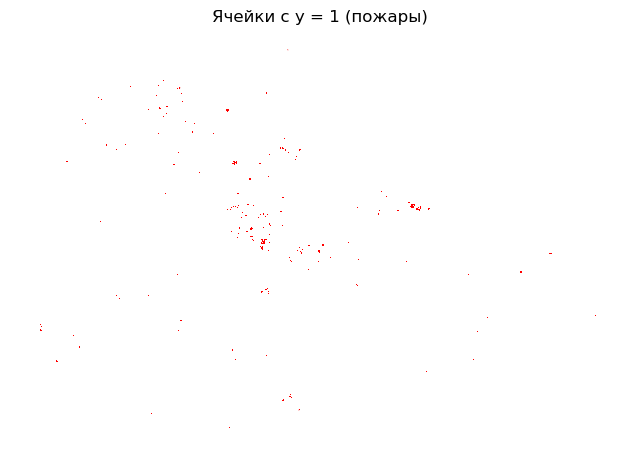

In [18]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 8))

grid[grid["y"] == 1].plot(
    ax=ax,
    color="red",
    markersize=1,
    label="Пожары"
)

ax.set_title("Ячейки с y = 1 (пожары)")
ax.axis("off")
plt.show()


In [19]:
grid.crs


<Projected CRS: EPSG:32642>
Name: WGS 84 / UTM zone 42N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 66°E and 72°E, northern hemisphere between equator and 84°N, onshore and offshore. Afghanistan. India. Kazakhstan. Kyrgyzstan. Pakistan. Russian Federation. Tajikistan. Uzbekistan.
- bounds: (66.0, 0.0, 72.0, 84.0)
Coordinate Operation:
- name: UTM zone 42N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich